In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 1: Load dataset path and we will focus on the train folder

In [ ]:
dataset_path = '/content/drive/MyDrive/garlic_alfina.v4i.voc/train'

Once we define the dataset path, ensure the path is properly configured. We should be able to see list of images and annotated images from train folder

In [ ]:
#Check if our dataset path has been properly setup
import os
print(os.listdir(dataset_path))

['camera1_garlic2_01_10_2025_14_02_03_jpg.rf.9368b7eee5134319d936b8c142168fa9.xml', 'camera1_garlic2_01_10_2025_14_02_03_jpg.rf.05797eb9768003ca48b54ab4fc4a4242.jpg', 'camera2_garlic4_01_10_2025_14_04_50_jpg.rf.a5d4af3bc73a252e2b6b882c86898687.xml', 'camera1_garlic5_01_10_2025_14_05_44_jpg.rf.470a49e0c2b604ef828d84a41da7ae4f.xml', 'camera2_garlic1_01_10_2025_14_01_02_jpg.rf.5da924043b53b59af4f4d20fb325a154.xml', 'camera2_garlic5_01_10_2025_14_05_33_jpg.rf.0d1c8fc0dcf86baa2d307113109bc801.xml', 'camera1_garlic2_01_10_2025_14_02_03_jpg.rf.9368b7eee5134319d936b8c142168fa9.jpg', 'camera2_garlic3_01_10_2025_14_03_47_jpg.rf.7d3e3d3cbe264f0f427437a1826c588a.xml', 'camera2_garlic3_01_10_2025_14_04_05_jpg.rf.69b20f3f51d79248cf43b4f6a736a40e.xml', 'camera1_garlic4_01_10_2025_14_04_50_jpg.rf.099a772833baf010729dd519e1f8d2b0.xml', 'camera2_garlic1_01_10_2025_14_00_53_jpg.rf.8a08bc1d9b79a81891f0fd7e96121372.xml', 'camera2_garlic2_01_10_2025_14_01_36_jpg.rf.4b91f14b5b2d5754e8978c03a3ce0313.xml', 'ca

Step 2: Install the required library

In [ ]:
!pip install -q torch torchvision opencv-python matplotlib

Step 3: Auto-generate File List

In [ ]:
import os

image_ids = sorted([
    os.path.splitext(f)[0]
    for f in os.listdir(dataset_path)
    if f.endswith('.jpg')
])

 Step 4: Create Custom Dataset Loader

 what you do here is basically load the dataset (in .xml format). In this step, you create a callable function to process the dataset and define each component inside your dataset (bounding boxed, labels and etc).

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET


class GarlicVOCDataset(Dataset):
    def __init__(self, root, image_ids, transforms=None):
        self.root = root
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root, img_id + '.jpg')
        annot_path = os.path.join(self.root, img_id + '.xml')

        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)

Step 5: Load Data and import pretrained Fast R-CNN Model

instead of building the model from scratch we will just use the pretrained model from torchvision library.

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset and call the dataset loader function we created earlier
dataset = GarlicVOCDataset(dataset_path, image_ids, transforms=ToTensor())
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load pretrained model and replace the head
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Step 6: Train the AI model using optimizer.
Optimizer is the algorithm that updates the model’s weights during training. It’s how we actually train the model.
For test, we are using SGD (Stochastic Gradient Descent), which adjusts the model slightly after each batch to reduce prediction errors.

In [ ]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
model.train()
for epoch in range(5):
    total_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/5] Loss: {total_loss:.4f}")

Epoch [1/5] Loss: 13.3691
Epoch [2/5] Loss: 6.6094
Epoch [3/5] Loss: 5.1065
Epoch [4/5] Loss: 4.1190
Epoch [5/5] Loss: 3.1360


here we are gonna use different optimizer to play around with the model. Our goal is to combine the right optimizer to train the AI to produce the best performance. Now we will try with Optimizer scheduler. This optimizer will automatically adjust the learning rate (epochs) over time based on the performance of the model in each rate.

In [ ]:
# Optimizer with scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

model.train()
for epoch in range(5):
    total_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    # keep updating the learning rate
    lr_scheduler.step()
    print(f"Epoch [{epoch + 1}/5] Loss: {total_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

Epoch [1/5] Loss: 2.5853, LR: 0.005000
Epoch [2/5] Loss: 2.2876, LR: 0.000500
Epoch [3/5] Loss: 1.8691, LR: 0.000500
Epoch [4/5] Loss: 1.6249, LR: 0.000050
Epoch [5/5] Loss: 1.5256, LR: 0.000050


In [ ]:
# Optimizer with gradient clipping
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

model.train()
for epoch in range(5):
    total_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/5] Loss: {total_loss:.4f}")

Epoch [1/5] Loss: 1.7748
Epoch [2/5] Loss: 2.0565
Epoch [3/5] Loss: 1.9064
Epoch [4/5] Loss: 1.7211
Epoch [5/5] Loss: 1.5828


In [ ]:
# Optimize the model and define the learning rate (for now i use 0.002)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.002, momentum=0.9, weight_decay=0.0005)

model.train()
for epoch in range(5):
    total_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = {k: v.item() for k, v in loss_dict.items()}
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/5] Total Loss: {total_loss:.4f} | Loss breakdown: {losses}")

Epoch [1/5] Total Loss: 1.3771 | Loss breakdown: {'loss_classifier': 0.009344197809696198, 'loss_box_reg': 0.01325557753443718, 'loss_objectness': 2.2715816157869995e-05, 'loss_rpn_box_reg': 0.00018530749366618693}
Epoch [2/5] Total Loss: 1.1389 | Loss breakdown: {'loss_classifier': 0.0054294331930577755, 'loss_box_reg': 0.006110509391874075, 'loss_objectness': 7.654607179574668e-05, 'loss_rpn_box_reg': 0.00032109650783240795}
Epoch [3/5] Total Loss: 1.0026 | Loss breakdown: {'loss_classifier': 0.0029389001429080963, 'loss_box_reg': 0.005085059441626072, 'loss_objectness': 1.2634062841243576e-05, 'loss_rpn_box_reg': 0.00039941311115399003}
Epoch [4/5] Total Loss: 0.9369 | Loss breakdown: {'loss_classifier': 0.012413729913532734, 'loss_box_reg': 0.017138106748461723, 'loss_objectness': 0.0013467841781675816, 'loss_rpn_box_reg': 0.0003195339231751859}
Epoch [5/5] Total Loss: 0.8778 | Loss breakdown: {'loss_classifier': 0.013055904768407345, 'loss_box_reg': 0.022520743310451508, 'loss_obj

Step 7: Import validation dataset path to generate performance matrix. We trained our model with a train dataset and we will use validation dataset to use as comparison to measure the model's performance.

In [ ]:
valid_path = "/content/drive/MyDrive/garlic_alfina.v4i.voc/valid"
valid_ids = sorted([
    os.path.splitext(f)[0]
    for f in os.listdir(valid_path)
    if f.endswith('.jpg')
])

valid_dataset = GarlicVOCDataset(valid_path, valid_ids, transforms=ToTensor())
import os
print(os.listdir(valid_path))

['camera2_garlic5_01_10_2025_14_05_44_jpg.rf.0f7ed0e3a114211b8ed25cae6f354db5.xml', 'camera2_garlic6_01_10_2025_14_06_48_jpg.rf.e09a8a8a6d26ceb9ef96b0648d62c147.xml', 'camera2_garlic2_01_10_2025_14_01_46_jpg.rf.8f511a3cf6caff2950235341691f697e.xml', 'camera2_garlic3_01_10_2025_14_03_56_jpg.rf.b81bf7ba7943ccfe3da2d3effea25917.jpg', 'camera2_garlic2_01_10_2025_14_02_03_jpg.rf.50232f72c081a5acef4b56040d0ee260.xml', 'camera2_garlic6_01_10_2025_14_06_38_jpg.rf.56b6081b87b0c7be50f6fa916a9898d2.xml', 'camera2_garlic3_01_10_2025_14_03_56_jpg.rf.b81bf7ba7943ccfe3da2d3effea25917.xml', 'camera2_garlic2_01_10_2025_14_02_03_jpg.rf.50232f72c081a5acef4b56040d0ee260.jpg', 'camera2_garlic7_01_10_2025_14_07_39_jpg.rf.85e09bc068d8701152ad70a772b86e80.xml', 'camera2_garlic2_01_10_2025_14_01_46_jpg.rf.8f511a3cf6caff2950235341691f697e.jpg', 'camera2_garlic5_01_10_2025_14_05_44_jpg.rf.0f7ed0e3a114211b8ed25cae6f354db5.jpg', 'camera2_garlic6_01_10_2025_14_06_38_jpg.rf.56b6081b87b0c7be50f6fa916a9898d2.jpg', 'ca

Base Configuration - first try with epoch 10

In [ ]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop. for now we will use 10 epochs
model.train()
for epoch in range(10):
    total_loss = 0.0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/5] Loss: {total_loss:.4f}")

Epoch [1/5] Loss: 0.9568
Epoch [2/5] Loss: 1.1577
Epoch [3/5] Loss: 1.3323
Epoch [4/5] Loss: 1.4037
Epoch [5/5] Loss: 1.3205
Epoch [6/5] Loss: 1.3139
Epoch [7/5] Loss: 1.4026
Epoch [8/5] Loss: 1.3056
Epoch [9/5] Loss: 1.1826
Epoch [10/5] Loss: 1.2328


Step 8: Training is completed. Now we need to create function to evaluate model performance

In [ ]:
!pip install torchmetrics
import torch
from torchvision.ops import box_iou

def evaluate_model(model, dataset, device, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    tp, fp, fn = 0, 0, 0

    with torch.no_grad():
        for img, target in dataset:
            img = img.to(device)
            true_boxes = target['boxes'].to(device)

            prediction = model([img])[0]
            pred_boxes = prediction['boxes'][prediction['scores'] > score_threshold]

            if len(pred_boxes) == 0:
                fn += len(true_boxes)
                continue

            ious = box_iou(pred_boxes, true_boxes)
            matched_gt = set()
            for row in ious:
                max_iou = torch.max(row).item()
                max_idx = torch.argmax(row).item()

                if max_iou >= iou_threshold and max_idx not in matched_gt:
                    tp += 1
                    matched_gt.add(max_idx)
                else:
                    fp += 1

            fn += len(true_boxes) - len(matched_gt)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    return {
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-score": round(f1, 4),
        "True Positives": tp,
        "False Positives": fp,
        "False Negatives": fn
    }

Step 9: Call evaluate_model function to generate performance matrix

In [ ]:
metrics = evaluate_model(model, valid_dataset, device)
print(metrics)

{'Precision': 0.7647, 'Recall': 0.8667, 'F1-score': 0.8125, 'True Positives': 13, 'False Positives': 4, 'False Negatives': 2}


we will train the AI model to go through each images in our dataset. number of epochs means the nr of time the AI Model will scan through each picture. If we define the epoch size to be 20 it means the AI model will scan / see the same picture 20 times.

In [ ]:
num_epochs = 20
train_losses = []
val_precisions = []
val_recalls = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss)
    metrics = evaluate_model(model, valid_dataset, device)
    val_precisions.append(metrics['Precision'])
    val_recalls.append(metrics['Recall'])

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss:.4f} | Precision: {metrics['Precision']} | Recall: {metrics['Recall']}")

Epoch [1/20] Loss: 1.1781 | Precision: 0.7647 | Recall: 0.8667
Epoch [2/20] Loss: 1.1770 | Precision: 0.7647 | Recall: 0.8667
Epoch [3/20] Loss: 1.2127 | Precision: 0.7647 | Recall: 0.8667
Epoch [4/20] Loss: 1.1913 | Precision: 0.8125 | Recall: 0.8667
Epoch [5/20] Loss: 1.0183 | Precision: 0.8125 | Recall: 0.8667
Epoch [6/20] Loss: 1.0144 | Precision: 0.8125 | Recall: 0.8667
Epoch [7/20] Loss: 0.8837 | Precision: 0.8125 | Recall: 0.8667
Epoch [8/20] Loss: 0.8928 | Precision: 0.8125 | Recall: 0.8667
Epoch [9/20] Loss: 0.9745 | Precision: 0.7647 | Recall: 0.8667
Epoch [10/20] Loss: 1.1462 | Precision: 0.7222 | Recall: 0.8667
Epoch [11/20] Loss: 0.9289 | Precision: 0.7647 | Recall: 0.8667
Epoch [12/20] Loss: 0.8968 | Precision: 0.7647 | Recall: 0.8667
Epoch [13/20] Loss: 0.7830 | Precision: 0.7647 | Recall: 0.8667
Epoch [14/20] Loss: 0.8013 | Precision: 0.8125 | Recall: 0.8667
Epoch [15/20] Loss: 0.8343 | Precision: 0.7647 | Recall: 0.8667
Epoch [16/20] Loss: 0.8214 | Precision: 0.8125 | 

Create visualization

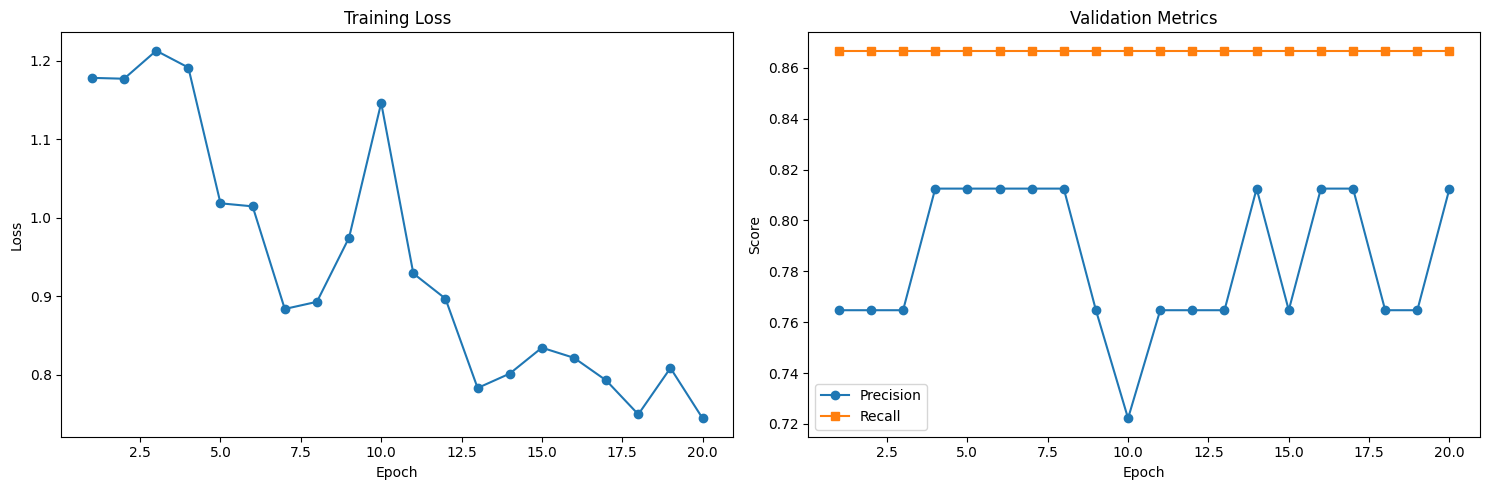

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Precision & Recall
plt.subplot(1, 2, 2)
plt.plot(epochs, val_precisions, marker='o', label='Precision')
plt.plot(epochs, val_recalls, marker='s', label='Recall')
plt.title("Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def generate_confusion_matrix(model, dataset, device, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for img, target in dataset:
            img = img.to(device)
            gt_boxes = target['boxes']
            pred = model([img])[0]
            pred_boxes = pred['boxes']
            scores = pred['scores']

            if len(pred_boxes) > 0:
                pred_boxes = pred_boxes[scores > score_threshold]

            ious = box_iou(pred_boxes, gt_boxes) if len(pred_boxes) > 0 and len(gt_boxes) > 0 else torch.zeros((0, 0))

            for i in range(len(pred_boxes)):
                if ious.shape[1] > 0 and torch.max(ious[i]) >= iou_threshold:
                    y_true.append(1)
                    y_pred.append(1)
                else:
                    y_true.append(0)
                    y_pred.append(1)

            for i in range(len(gt_boxes)):
                if ious.shape[0] == 0 or torch.max(ious[:, i]) < iou_threshold:
                    y_true.append(1)
                    y_pred.append(0)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background", "Garlic"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()